In [723]:
%load_ext autoreload
%autoreload 2


# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Signal Processing ===
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from helper_functions import extract_spectrograms
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr
from helper_functions import return_train_val_loaders

import json

## We will load some small dataset for testing first

In [724]:
# Helper function to load and filter metadata
def load_filtered_metadata(path, channel="BH", source_type=None):
    df = pd.read_csv(path)
    df = df[df["station_channel_code"] == channel]
    if source_type:
        df = df[df["source_type"] == source_type]
    return df

# Paths
base_path = "/data/whd01/yiyu_data/PNWML"
exotic_path = f"{base_path}/exotic_metadata.csv"
noise_path = f"{base_path}/noise_metadata.csv"
comcat_path = f"{base_path}/comcat_metadata.csv"

# Load filtered datasets
exotic = load_filtered_metadata(exotic_path, source_type="surface event")
noise = load_filtered_metadata(noise_path, source_type="noise")
comcat = load_filtered_metadata(comcat_path)

# Split comcat into earthquake and explosion
eq = comcat[comcat["source_type"] == "earthquake"]
exp = comcat[comcat["source_type"] == "explosion"]


noise = noise[0:200]
exotic = exotic[0:200]
eq = eq[0:200]
exp = exp[0:200]

#Now concatenate all of them into one DataFrame#
combined_df = pd.concat([noise, exotic, eq, exp], ignore_index=True)

In [725]:
event = eq.iloc[3]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                                   uw10568748
source_origin_time                        2002-09-26T07:00:04.860000Z
source_latitude_deg                                            48.481
source_longitude_deg                                         -123.133
source_type                                                earthquake
source_depth_km                                                22.748
preferred_source_magnitude                                        2.9
preferred_source_magnitude_type                                    md
preferred_source_magnitude_uncertainty                           0.03
source_depth_uncertainty_km                                      0.91
source_horizontal_uncertainty_km                                0.672
station_network_code                                               UW
station_channel_code                                               BH
station_code                                                      SQM
station_location_cod

## New seisbench friendly (pytorch) functions

In [726]:
# Parameters
LOWCUT = 1
HIGHCUT = 20
FS = 50
ORDER = 4


def linear_detrend(batch: torch.Tensor) -> torch.Tensor:
    """
    Remove linear trend from each trace (B, C, T)
    """
    time = torch.arange(batch.shape[-1], dtype=batch.dtype, device=batch.device)
    time_mean = time.mean()
    time_var = ((time - time_mean) ** 2).sum()
    slope = ((batch * (time - time_mean)).sum(dim=-1, keepdim=True)) / time_var
    intercept = batch.mean(dim=-1, keepdim=True) - slope * time_mean
    trend = slope * time + intercept
    return batch - trend


def taper_tukey(batch: torch.Tensor, alpha: float = 0.1) -> torch.Tensor:
    """
    Apply Tukey taper (B, C, T)
    """
    tukey_window = scipy.signal.windows.tukey(batch.shape[-1], alpha=alpha)
    window = torch.tensor(tukey_window, dtype=batch.dtype, device=batch.device)
    return batch * window


def bandpass_filter(batch: torch.Tensor, fs: float = FS, lowcut: float = LOWCUT, highcut: float = HIGHCUT, order: int = ORDER) -> torch.Tensor:
    """
    Apply filtfilt bandpass filter to tensor (B, C, T)
    """
    numpy_batch = batch.cpu().numpy()
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')

    filtered = np.zeros_like(numpy_batch)
    for i in range(numpy_batch.shape[0]):
        for j in range(numpy_batch.shape[1]):
            filtered[i, j] = filtfilt(b, a, numpy_batch[i, j])

    return torch.tensor(filtered, dtype=batch.dtype, device=batch.device)


def normalize_per_trace(batch: torch.Tensor) -> torch.Tensor:
    """
    Normalize each trace using global std across all channels
    """
    stds = torch.std(torch.abs(batch.reshape(batch.shape[0], -1)), dim=1, keepdim=True)
    stds = stds.view(-1, 1, 1)
    return batch / (stds + 1e-10)


def compute_spectrogram(batch: torch.Tensor, fs: int = FS, nperseg: int = 256, overlap: float = 0.5):
    """
    Compute PSD spectrogram (B, C, T) → (B, C, F, T_spec)
    """
    B, C, N = batch.shape
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    win = torch.hann_window(nperseg, periodic=True, dtype=batch.dtype, device=batch.device)
    
    segs = batch.unfold(-1, nperseg, hop)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    segs = segs * win

    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0

    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(batch.device)
    times = (torch.arange(psd.shape[-1], dtype=batch.dtype, device=batch.device) * hop + nperseg // 2) / fs

    return psd, freqs, times



def normalize_spectrogram_minmax(spectrogram: torch.Tensor) -> torch.Tensor:
    """
    Normalize each trace spectrogram (B, C, F, T) independently to [0, 1]
    """
    B, C, F, T = spectrogram.shape
    spec_flat = spectrogram.reshape(B, C, -1)
    min_vals = spec_flat.min(dim=-1, keepdim=True)[0].view(B, C, 1, 1)
    max_vals = spec_flat.max(dim=-1, keepdim=True)[0].view(B, C, 1, 1)
    return (spectrogram - min_vals) / (max_vals - min_vals + 1e-10)




def plot_waveforms(waveform, title):
    
    components = ['Z', 'N', 'E']
    fs = 50  # sampling rate in Hz
    time = np.arange(waveform.shape[1]) / fs  # convert sample index to seconds

    plt.figure(figsize=(12, 8))

    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(time, waveform[i], linewidth=1.2)
        plt.title(f"{components[i]} Component", fontsize=14)
        plt.ylabel("Amplitude", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        if i == 2:
            plt.xlabel("Time (s)", fontsize=12)
        else:
            plt.xticks([])  # hide x-ticks for top plots to reduce clutter

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust layout to fit suptitle
    plt.show()
    
    

## Visualizaing the output at each step

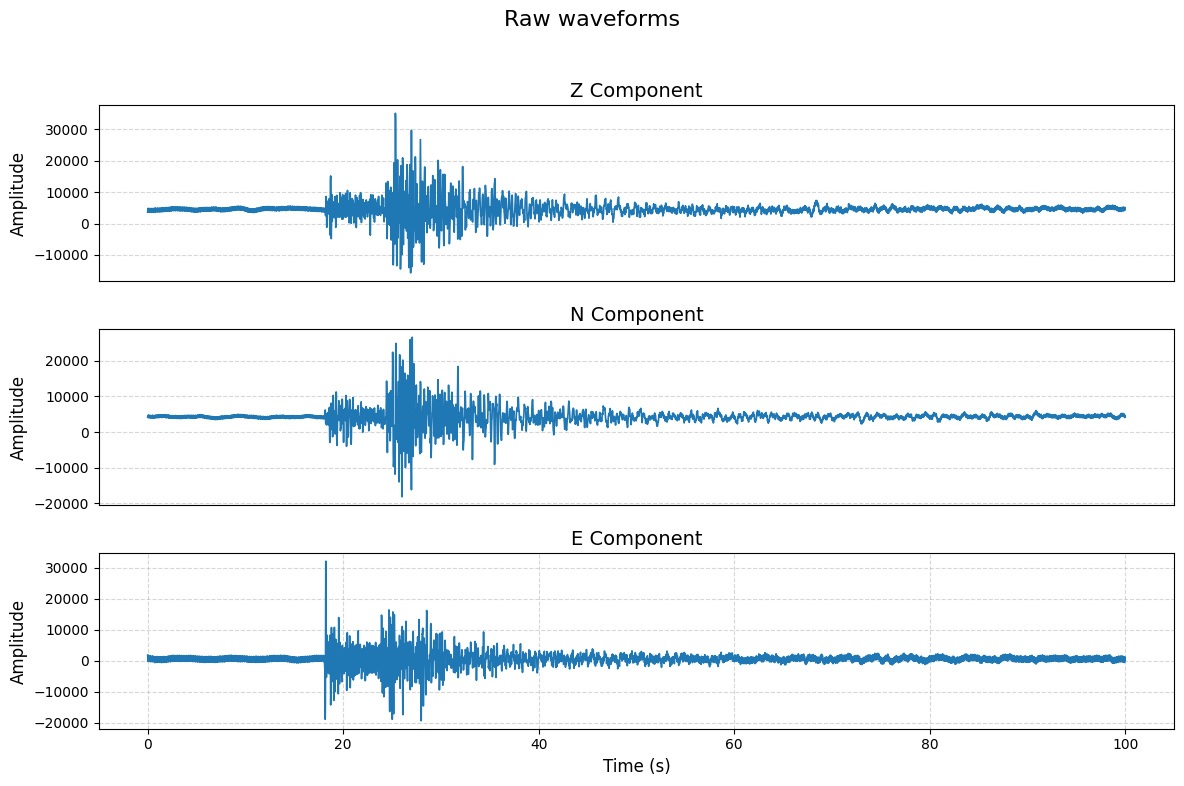

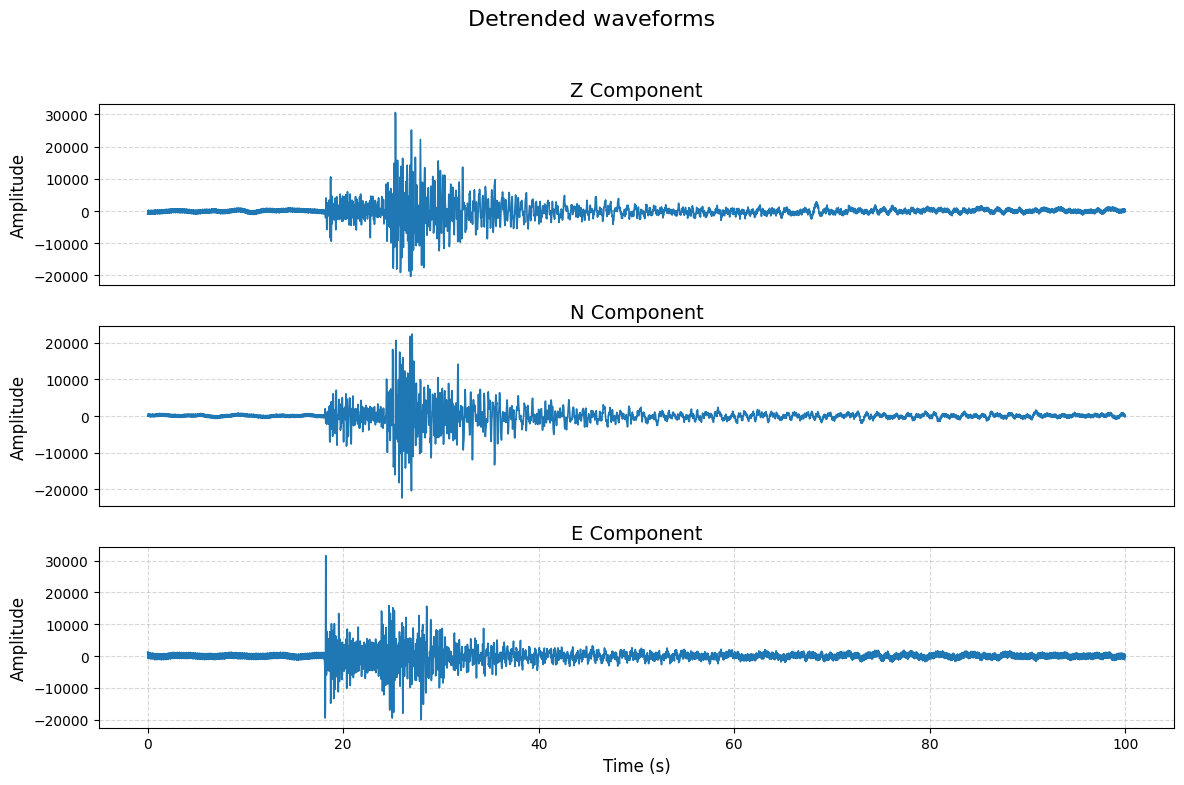

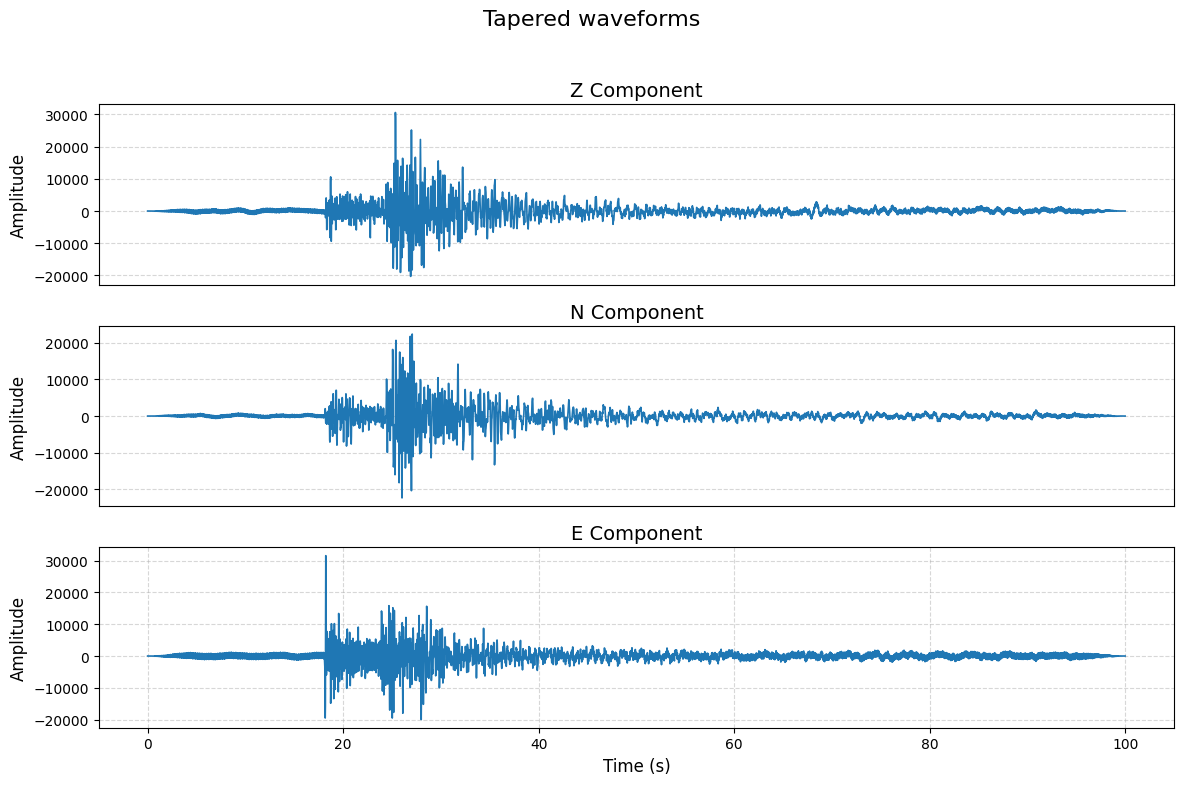

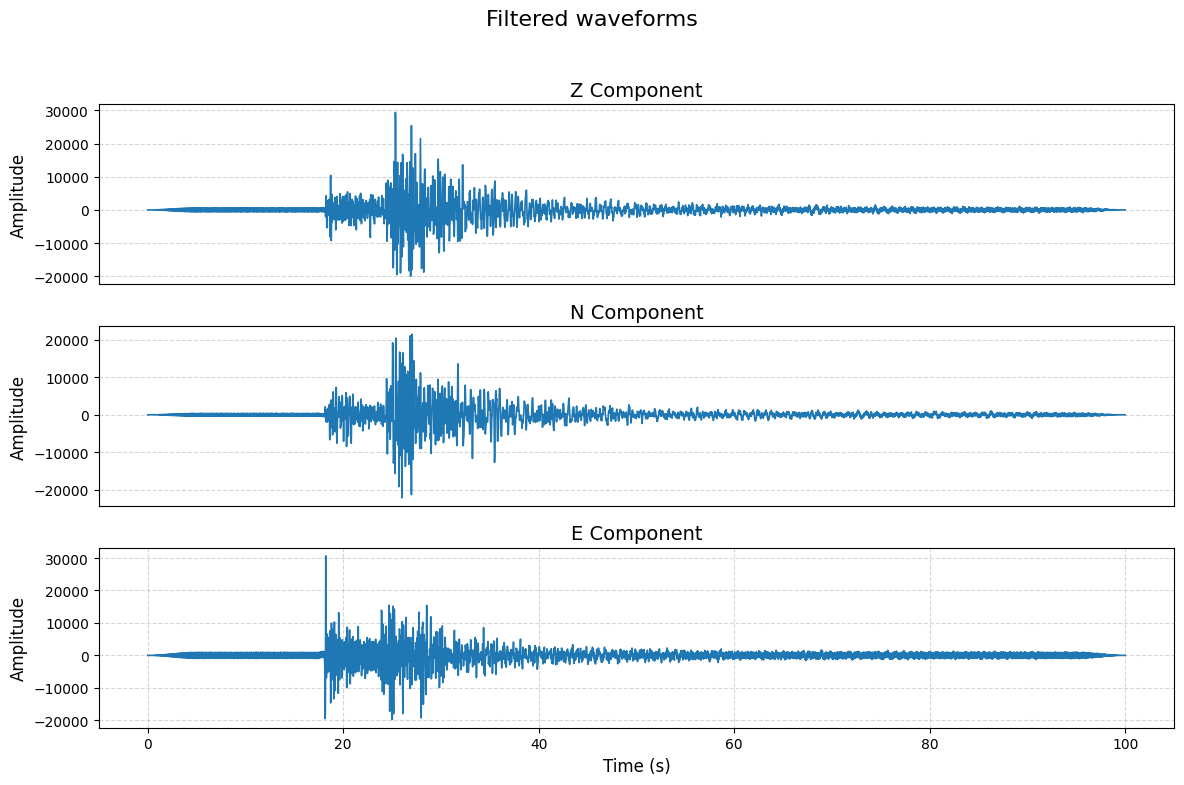

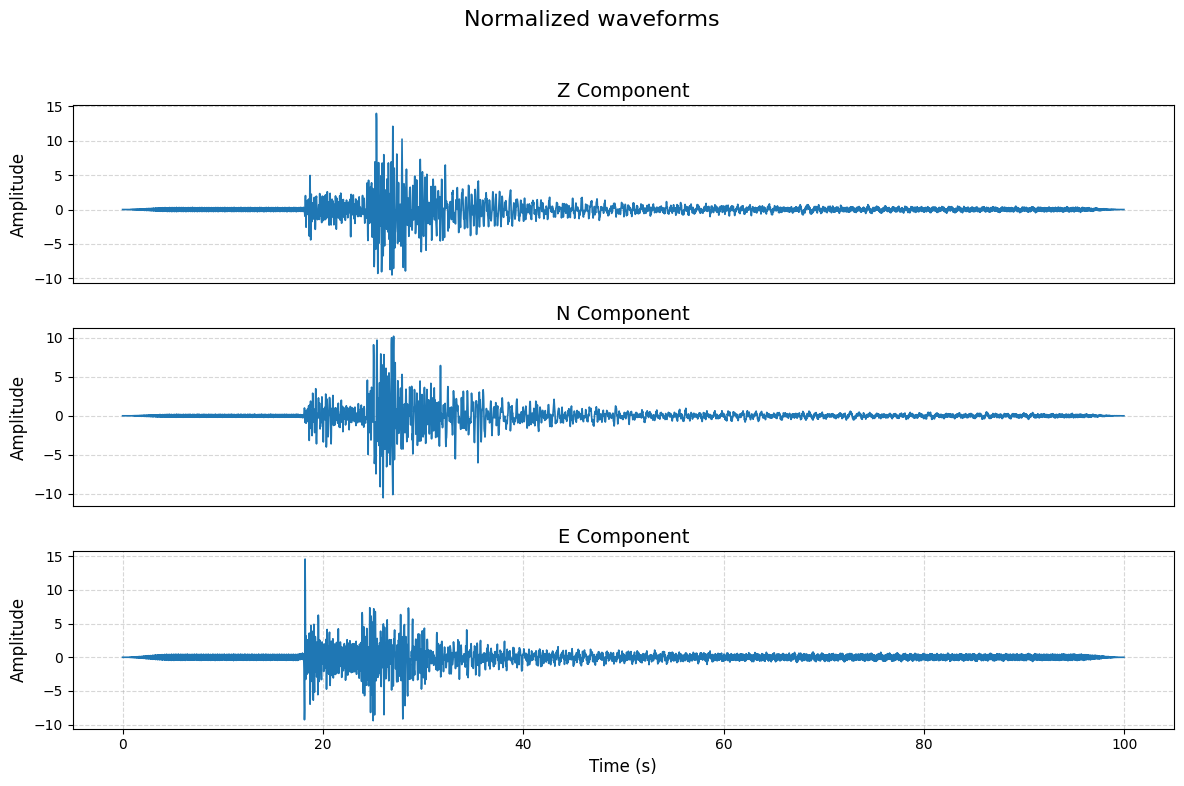

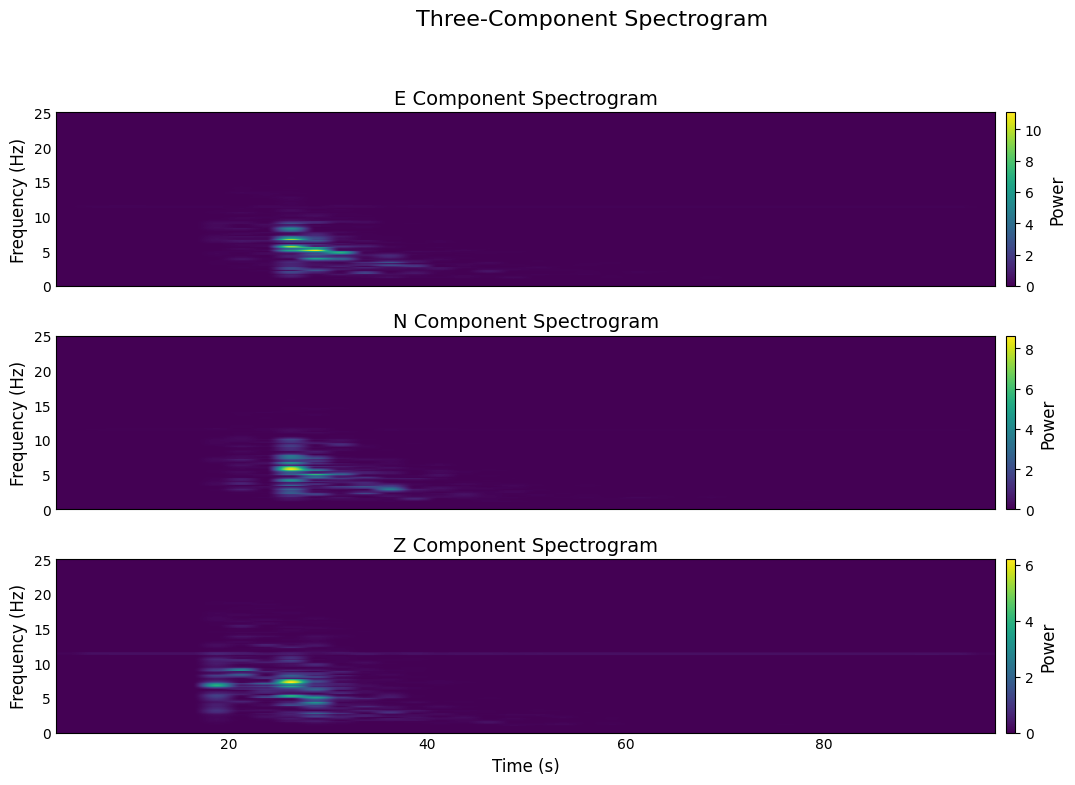

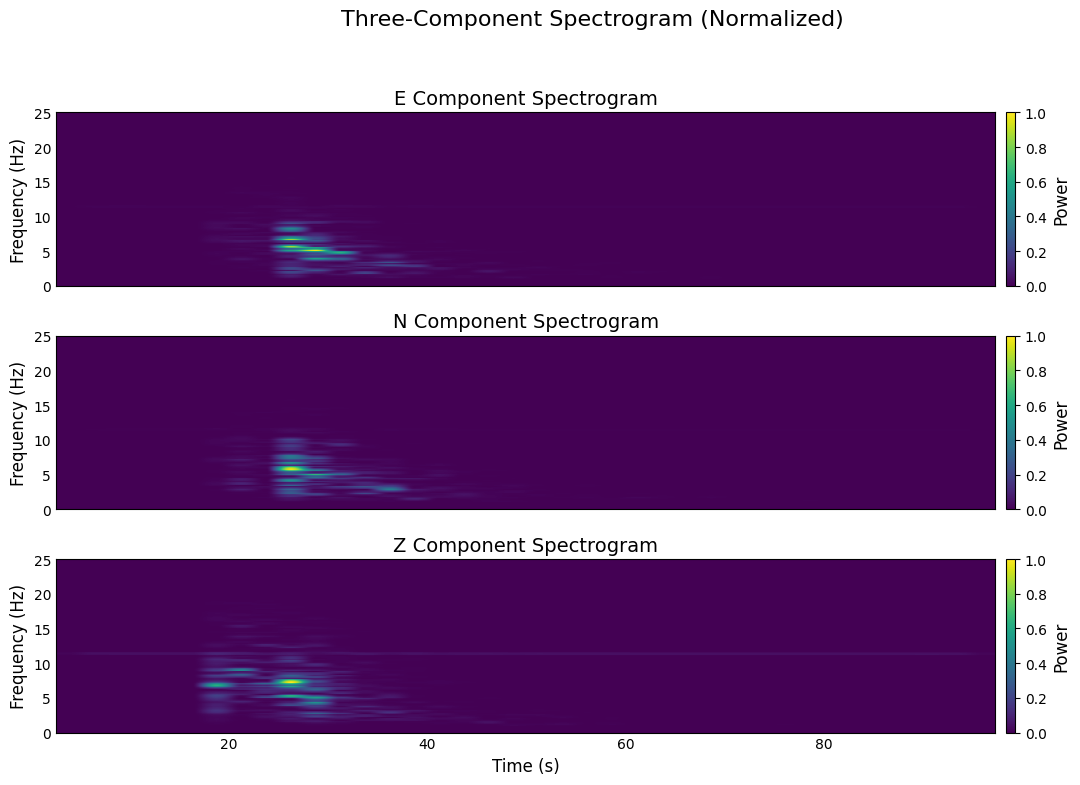

In [727]:
fs = 50
lowcut = 1
highcut = 20

## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime+40, endtime=starttime+ 140)

fs_orig = s[0].stats.sampling_rate

# converting into array
event_data = np.array(s)[:, :5000]

# reshaping for shape compatibility
event_data = event_data.reshape(1, 3, 5000)

# converting into pytorch tensor. 
batch = torch.tensor(event_data, dtype=torch.float32)
plot_waveforms(batch[0], 'Raw waveforms')

# detrending
batch = linear_detrend(batch)
plot_waveforms(batch[0], 'Detrended waveforms')


# tapering
batch = taper_tukey(batch)
plot_waveforms(batch[0], 'Tapered waveforms')
        
# filtering
batch = bandpass_filter(batch, fs=fs, lowcut = lowcut, highcut = highcut)
plot_waveforms(batch[0], 'Filtered waveforms')


# resampling
target_len = int(batch.shape[-1] * fs / fs_orig)
batch = F.interpolate(batch, size=target_len, mode='linear', align_corners=False)


# normalizing
batch = normalize_per_trace(batch)
plot_waveforms(batch[0], 'Normalized waveforms')

# Extracting spectrogram (returns: psd, freqs, times)
psd, freqs, times = compute_spectrogram(batch, fs=50, nperseg=256, overlap=0.5)

# Get the spectrogram for the first waveform (shape: [3, F, T])
spectrogram = psd[0].cpu().numpy()
times = times.cpu().numpy()
freqs = freqs.cpu().numpy()

# Component names
components = ['E', 'N', 'Z']

# Plottingn
plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[times[0], times[-1], freqs[0], freqs[-1]]
    )

    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency (Hz)", fontsize=12)
    ax.grid(False)
    ax.tick_params(axis='both', length=0)

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time (s)", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




psd = normalize_spectrogram_minmax(psd)
# Get the spectrogram for the first waveform (shape: [3, F, T])
spectrogram = psd[0].cpu().numpy()
times = times
freqs = freqs

# Component names
components = ['E', 'N', 'Z']

# Plotting
plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[times[0], times[-1], freqs[0], freqs[-1]]
    )

    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency (Hz)", fontsize=12)
    ax.grid(False)
    ax.tick_params(axis='both', length=0)

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time (s)", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Normalized)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Wrapping all the functions in a single code cell for enhanced reproducibility

In [728]:
class WaveformPreprocessor:
    def __init__(self, input_fs=100, target_fs=50, lowcut=1, highcut=20, order=4, taper_alpha=0.1):
        self.input_fs = input_fs
        self.target_fs = target_fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.order = order
        self.taper_alpha = taper_alpha

    def __call__(self, waveform: torch.Tensor) -> torch.Tensor:
        """
        Preprocess a single waveform: detrend, taper, filter, resample, normalize.
        Input:  (C, T) or (1, C, T)
        Output: (C, T_new)
        """
        if waveform.ndim == 2:
            waveform = waveform.unsqueeze(0)  # → (1, C, T)
        
        x = waveform.clone()

        x = self._linear_detrend(x)
        x = self._taper_tukey(x, alpha=self.taper_alpha)
        x = self._bandpass_filter(x, fs=self.input_fs, lowcut=self.lowcut, highcut=self.highcut, order=self.order)
        x = self._resample(x, self.input_fs, self.target_fs)
        x = self._normalize_per_trace(x)

        return x.squeeze(0)  # → (C, T_new)

    def _linear_detrend(self, batch: torch.Tensor) -> torch.Tensor:
        time = torch.arange(batch.shape[-1], dtype=batch.dtype, device=batch.device)
        time_mean = time.mean()
        time_var = ((time - time_mean) ** 2).sum()
        slope = ((batch * (time - time_mean)).sum(dim=-1, keepdim=True)) / time_var
        intercept = batch.mean(dim=-1, keepdim=True) - slope * time_mean
        trend = slope * time + intercept
        return batch - trend

    def _taper_tukey(self, batch: torch.Tensor, alpha: float = 0.1) -> torch.Tensor:
        tukey_window = scipy.signal.windows.tukey(batch.shape[-1], alpha=alpha)
        window = torch.tensor(tukey_window, dtype=batch.dtype, device=batch.device)
        return batch * window

    def _bandpass_filter(self, batch: torch.Tensor, fs: float, lowcut: float, highcut: float, order: int) -> torch.Tensor:
        numpy_batch = batch.cpu().numpy()
        nyquist = 0.5 * fs
        b, a = scipy.signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')

        filtered = np.zeros_like(numpy_batch)
        for i in range(numpy_batch.shape[0]):
            for j in range(numpy_batch.shape[1]):
                filtered[i, j] = scipy.signal.filtfilt(b, a, numpy_batch[i, j])

        return torch.tensor(filtered, dtype=batch.dtype, device=batch.device)

    def _resample(self, batch: torch.Tensor, fs_in: float, fs_out: float) -> torch.Tensor:
        orig_len = batch.shape[-1]
        new_len = int(orig_len * fs_out / fs_in)
        return F.interpolate(batch, size=new_len, mode='linear', align_corners=False)

    def _normalize_per_trace(self, batch: torch.Tensor) -> torch.Tensor:
        stds = torch.std(torch.abs(batch.reshape(batch.shape[0], -1)), dim=1, keepdim=True)
        stds = stds.view(-1, 1, 1)
        return batch / (stds + 1e-10)

    
    
def extract_waveforms(cat, file_name, start=-20, input_window_length=100, fs=50, number_data=1000,
                      num_channels=3, all_data=False, shifting=True, lowcut=1, highcut=10):
    """
    Extract and preprocess waveform windows using the WaveformPreprocessor.
    """

    random.seed(1234)
    cat = cat.sample(frac=1).reset_index(drop=True)
    cat = cat.reset_index(drop = True)
    

    if all_data:
        number_data = len(cat)

    f = h5py.File(file_name, 'r')

    x = np.zeros(shape=(number_data, 3, int(fs * input_window_length)))
    event_ids = cat['event_id'].values + '_' + cat['station_network_code'].values + '.' + cat['station_code'].values

    if not all_data:
        event_ids = event_ids[:number_data]

    for index in tqdm(range(number_data)):
        bucket, narray = cat.loc[index]['trace_name'].split('$')
        xx, _, _ = [int(i) for i in narray.split(',:')]
        data = f[f'/data/{bucket}'][xx, :, :]  # (3, T)

        original_fs = cat.loc[index, 'trace_sampling_rate_hz']
        trace_len = data.shape[-1]
        window_len = int(original_fs * input_window_length)

        # Determine istart, iend
        if "noise" in event_ids[index].split("_")[1]:
            istart = 0
        else:
            shift_samples = int(np.random.randint(start, -4) * original_fs)

            if np.isnan(cat.loc[index, 'trace_P_arrival_sample']):
                assumed_p_sample = int(7000)
                istart = assumed_p_sample + shift_samples
            else:
                p_sample = int(cat.loc[index, 'trace_P_arrival_sample'])
                istart = p_sample + shift_samples

        istart = max(0, istart)
        iend = istart + window_len
        
        if iend > trace_len:
            istart = max(0, istart - (iend - trace_len))
            iend = window_len

        # Safety check
        if iend - istart != window_len:
            continue

            

        sliced = data[:, istart:iend]
        sliced_tensor = torch.tensor(sliced, dtype=torch.float32)

        processor = WaveformPreprocessor(
            input_fs=original_fs,
            target_fs=fs,
            lowcut=lowcut,
            highcut=highcut
        )

        processed = processor(sliced_tensor)  # (C, T)
        
        if processed.shape[-1] != int(window_len*fs/original_fs):
            print('error')
            continue
            
        x[index, :, :] = processed.numpy()
        
    

    # Drop zero-filled entries
    if num_channels == 1:
        x2 = x[:, 2, :]
        x = x2.reshape(x2.shape[0], 1, x2.shape[1])
        idx = np.where(np.mean(np.abs(x[:, 0, 0:10]), axis=-1) > 0)[0]
    else:
        idx = np.where(np.mean(np.abs(x[:, 0, 0:10]), axis=-1) > 0)[0]

    f.close()
    return x[idx, :, :], event_ids[idx]